# Shrinkage Methods
References:
*Elements of Statistical Learning* - Hastie, Tibshirani, Friedman


Shrinkage methods aim to decrease prediction error by introducing a bias that shrinks the coefficients obtained using OLS. This is achieved by minimizing RSS plus a penalty term. Being less fit to the training data, the model has bias but less variance among different possible training sets. OLS has low bias because it is fit to the data, but high variance because it will be fit to whatever sample is used.

The most basic shrinkage methods are ridge and lasso regression.


## Ridge Regression

Recall that OLS minimizes RSS. Ridge minimizes RSS plus a lambda parameter times the sum of the squares of the coefficients. Here is how that looks:

$$\text{RSS} + \lambda \sum_{j=1}^{p} \beta_j^2$$

Note that the intercept is not included in the penalty term and that $\lambda \ge 0$. Lambda has to be tuned separately. When $\lambda = 0$, ridge regression is equivalent to OLS. As $\lambda$ approaches infinity, the coefficients approach 0.

In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Data

It is important to note that the inputs for ridge regression are generally standardized. With multiple features of different scales, the penalty would otherwise not have a uniform effect. If standardized (or centered), the intercept will be $\bar{y}$. In the case of one feature with a coefficient approaching 0, $\bar{y}$ would minimize the residuals.

The rest of the coefficients follow a similar form to OLS:

$$\hat{\beta}_{ridge} =(X^TX + \lambda I)^{-1} X^{T}y$$

In [380]:
train_df = pd.read_pickle('Data/prostate.pkl').query("train == 'T'")
test_df = pd.read_pickle('Data/prostate.pkl').query("train == 'F'")
features = train_df.columns.to_list()
features = [item for item in features if item not in ['lpsa', 'train']]

In [381]:
X = train_df[features]  # No intercept column
y = np.array(train_df['lpsa'])

beta_0 = y.mean()

l = 20  # Placeholder lambda
id_mat = np.identity(len(features))  # p * p identity matrix
beta = np.linalg.inv((X.T @ X) + (l * id_mat)) @ (X.T @ y)  # the inverse function is slow, so don't actually do this

np.append(beta_0, beta)

array([ 2.45234509,  0.45349457,  0.25880337, -0.05349493,  0.17410649,
        0.24167883, -0.01017014,  0.04019622,  0.14034449])

## Statsmodels and SciKit-Learn

Using Statsmodels for ridge regression is a little more annoying, which is why I will also introduce SciKit-Learn. This will also show why it is important to understand how a library/package implements a model, what defaults it has, and what the inputs are.

Notes on Statsmodels:
The penalty term which is called alpha instead of lambda is applied to every term including the intercept which we don't want. Instead, we are able to pass a vector with the first term being 0. Lambda is also scaled by the number of data points, so for comparison we must divide by n. You don't normally have to do this since you would still be searching for what lambda works the best, but it is important to note.

In [382]:
# Statsmodels
# Same Patsy setup as before
rhs = 'lpsa ~ lcavol + lweight + age + lbph + svi + lcp + gleason + pgg45'
y, X = patsy.dmatrices(rhs, train_df)

# We still use OLS to build the model
linear_model = sm.regression.linear_model.OLS(y,X)

# Create the lambda array
lambdas = np.zeros(9)
lambdas[1:] = 20 / train_df.shape[0]  # Keep the intercept's lambda as 0

# fit_regularized instead of fit, supply lambda vector, and set L1_wt to 0 for ridge (1 is LASSO)
results = linear_model.fit_regularized(alpha=lambdas,L1_wt=0.0)

# .summary() is not implemented yet
results.params

array([ 2.45234509,  0.45349457,  0.25880337, -0.05349493,  0.17410649,
        0.24167883, -0.01017014,  0.04019622,  0.14034449])

In [383]:
# sklearn
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=20, fit_intercept=True)

X = train_df[features]
y = np.array(train_df['lpsa'])

ridge_reg.fit(X, y)  # Note X, y instead of y, X
np.append(ridge_reg.intercept_, ridge_reg.coef_)

array([ 2.45234509,  0.45349457,  0.25880337, -0.05349493,  0.17410649,
        0.24167883, -0.01017014,  0.04019622,  0.14034449])

Here's how the coefficients shrink as lambda increases:

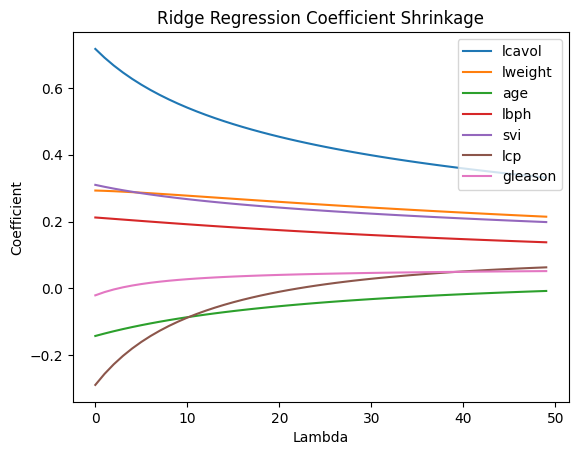

In [384]:
coeff_array = np.zeros((50,10))

for i in range(50):
    ridge_reg = Ridge(alpha=i, fit_intercept=True)
    ridge_reg.fit(X, y)
    coeff_array[i,:] = np.append(np.append(ridge_reg.intercept_, ridge_reg.coef_),i)
    
plt.plot(coeff_array[:,9], coeff_array[:,1:8])
plt.title('Ridge Regression Coefficient Shrinkage')
plt.ylabel('Coefficient')
plt.xlabel('Lambda')
plt.legend(features);

## Lasso

Where the coefficient of less impactful features tend to 0 in ridge regression, lasso's penalty can set them to 0. Additionally instead of an L2-norm penalty term, lasso uses an L1-norm penalty. So we are minimizing:
$$\text{RSS} + \lambda \sum_{j=1}^{p} |\beta_j|$$ 

Because the absolute value is not differentiable, there is no closed form solution like there is for ridge and ols.

Note that StatsModel and SciKit-Learn use the same lambda (alpha), but we may see slightly different results based on the functions work.

In [385]:
# Statsmodels
# Same Patsy setup as before
rhs = 'lpsa ~ lcavol + lweight + age + lbph + svi + lcp + gleason + pgg45'
y, X = patsy.dmatrices(rhs, train_df)

# We still use OLS to build the model
linear_model = sm.regression.linear_model.OLS(y,X)

# Create the lambda array
lambdas = np.zeros(9)
lambdas[1:] = 10 / train_df.shape[0]

# fit_regularized instead of fit, supply lambda vector, and set L1_wt to 1 for LASSO
results = linear_model.fit_regularized(alpha=lambdas,L1_wt=1.0)

# .summary() is not implemented yet
results.params

array([2.45234509, 0.56899064, 0.21100748, 0.        , 0.05799238,
       0.13671977, 0.        , 0.        , 0.03503067])

In [386]:
# sklearn
from sklearn.linear_model import Lasso

l = 10 / train_df.shape[0]
lasso_reg = Lasso(alpha=l, fit_intercept=True)

X = train_df[features]
y = np.array(train_df['lpsa'])

lasso_reg.fit(X, y)  # Note X, y instead of y, X
np.append(lasso_reg.intercept_, lasso_reg.coef_)

array([2.45234509, 0.5689806 , 0.21100084, 0.        , 0.05799792,
       0.13672137, 0.        , 0.        , 0.03503541])

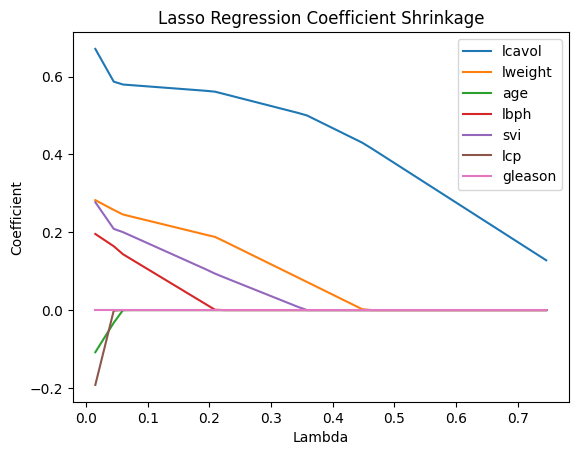

In [387]:
coeff_array = np.zeros((50,10))

n = train_df.shape[0]

for i in range(1,51):
    lasso_reg = Lasso(alpha=i/n, fit_intercept=True)
    lasso_reg.fit(X, y)
    coeff_array[i-1,:] = np.append(np.append(lasso_reg.intercept_, lasso_reg.coef_),i/n)
    
plt.plot(coeff_array[:,9], coeff_array[:,1:8])
plt.title('Lasso Regression Coefficient Shrinkage')
plt.ylabel('Coefficient')
plt.xlabel('Lambda')
plt.legend(features);

And here we see that the coefficients go exactly to zero.

## Cross Validation

Cross validation splits the data into K folds that are approximately the same size. Each fold is used as a testing set, while the other K-1 folds are used to build a model. The average of the error on the left out fold can be used to estimate prediction error, but our focus here is to use cross validation for selecting a parameter. So for a variety of possible lambdas, we will run a CV to estimate the prediction error and use the lambda with the lowest error estimate. 

An important note is that we don't want to leak any data from a testing set into a training set. The textbook example is using correlation on the entire dataset to select predictors and then running cross validation. The estimated prediction error is inflated because the predictors were chosen for their performance on all data. For a testing set to be useful, it should not be used in the training set.

Currently, the training set is standardized, but we will want to do this for each new "training" set (K-1 folds) and apply the same mean and standard deviation to the testing set (Kth fold).

 How big should the folds be? 
 Ideally we have an idea of how much data is needed to train a model, but this is sometimes hard to know when we do not have much data. Using a 10-fold or 5-fold CV is fairly standard. I will use a 5-fold because of the small amount of data.
 
### Ridge Regression CV for Lambda

In [388]:
# Load in original dataset (earlier dataset was preprocessed)
prostate_df = pd.read_excel('Data/Prostate Cancer Data.xlsx', 'prostate').drop(columns=['Unnamed: 0'])
cv_df = prostate_df.query("train == 'T'").copy().drop(columns=['train'])
#cv_y = prostate_df.query("train == 'T'").copy().lpsa

In [389]:
# Create roughly equal partitions for 5 folds
K = 10
partition = np.zeros((K, 2), dtype=int)

n = train_df.shape[0]
last = 0
for i in range(K):
    psize = int(np.ceil(n / (K - i)))
    partition[i, :] = [last, last + psize-1]
    last += psize
    n -= psize

In [390]:
# Load in original dataset (earlier dataset was preprocessed)
prostate_df = pd.read_excel('Data/Prostate Cancer Data.xlsx', 'prostate').drop(columns=['Unnamed: 0'])
cv_df = prostate_df.query("train == 'T'").copy().drop(columns=['train'])
cv_df = cv_df.sample(frac=1, random_state=0)  # Shuffle df, so not sorted

lambdas = [i for i in range(1,40)]
errors = np.zeros(len(lambdas))

for j in range(K):
    train = cv_df.drop(cv_df.index[partition[j,0]:partition[j,1]+1])  # K - 1 folds
    test = cv_df[partition[j,0]:partition[j,1]+1]  # Kth fold

    y_train = train.lpsa
    X_train = train.drop(columns='lpsa')
    y_test = test.lpsa
    X_test = test.drop(columns='lpsa')
    
    train_mean = X_train.mean()
    train_std = X_train.std(ddof=0)
    
    X_train = (X_train-train_mean) / train_std  # Standardize train/test with train mean/std
    X_test = (X_test-train_mean) / train_std
    
    for i in range(len(lambdas)):
        
        ridge_reg = Ridge(alpha=lambdas[i], fit_intercept=True)  # Fit and predict
        ridge_reg.fit(X_train, y_train)
        pred_test = ridge_reg.predict(X_test)

        errors[i] += ((pred_test - y_test) ** 2).sum()

errors /= cv_df.shape[0]

lambdas[np.argmin(errors)]  # Best lambda value found

4

In [391]:
errors

array([0.62345871, 0.62013555, 0.61838036, 0.61767677, 0.61769623,
       0.61822304, 0.61911179, 0.62026228, 0.62160412, 0.62308706,
       0.6246747 , 0.62634036, 0.62806427, 0.62983163, 0.63163128,
       0.63345473, 0.6352955 , 0.6371486 , 0.63901017, 0.64087721,
       0.64274739, 0.6446189 , 0.64649031, 0.6483605 , 0.65022859,
       0.6520939 , 0.65395588, 0.65581412, 0.65766827, 0.65951808,
       0.66136336, 0.66320394, 0.6650397 , 0.66687056, 0.66869643,
       0.67051728, 0.67233307, 0.67414376, 0.67594935])

In [392]:
# Fitting all data on best lambda
X = (cv_df[features] - cv_df[features].mean()) / cv_df[features].std(ddof=0) 
y = np.array(cv_df['lpsa'])
ridge_reg = Ridge(alpha=4, fit_intercept=True)
ridge_reg.fit(X, y)
np.append(ridge_reg.intercept_, ridge_reg.coef_)

array([ 2.45234509,  0.62319319,  0.28573645, -0.11538444,  0.20231712,
        0.28708232, -0.17994724,  0.00802209,  0.21491203])

In [393]:
# Sklearn also has a RidgeCV function
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
lambdas = [i for i in range(1,40)]

pipe = Pipeline([("scaler", StandardScaler()),
                 ("ridge", RidgeCV(alphas=lambdas, cv=10, scoring='neg_mean_squared_error'))])

X = cv_df[features]  # fit with unscaled and shuffled df
y = np.array(cv_df.lpsa)

pipe.fit(X, y)
pipe.named_steps['ridge'].alpha_  # best lambda

5

It finds a lambda of 5 instead of 4. My best guess is it has to do something with the scaling, partitioning, or cross validation implementation.

In [394]:
pipe.named_steps['ridge'].best_score_  # The error is also slightly different

-0.616580968538391

In [395]:
np.append(pipe.named_steps['ridge'].intercept_, pipe.named_steps['ridge'].coef_) 

array([ 2.45234509,  0.60610311,  0.28418057, -0.10982178,  0.20029913,
        0.28289364, -0.16052082,  0.0124514 ,  0.20501262])

Running all data with a lambda of 5 shows that it does get the same coefficients

In [396]:
X = (cv_df[features] - cv_df[features].mean()) / cv_df[features].std(ddof=0) 
y = np.array(cv_df['lpsa'])
ridge_reg = Ridge(alpha=5, fit_intercept=True)
ridge_reg.fit(X, y)
np.append(ridge_reg.intercept_, ridge_reg.coef_)

array([ 2.45234509,  0.60610311,  0.28418057, -0.10982178,  0.20029913,
        0.28289364, -0.16052082,  0.0124514 ,  0.20501262])

I looked into why there might be a difference, but couldn't figure it out. It very well could be something on my end or goes to show that you should know exactly how a package implements something.